# 2023 Immune dataset H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

**TCell**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR763CQW/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR716VIQ/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR395YXN/
Control https://www.encodeproject.org/experiments/ENCSR930RIA/
**BCell**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR449GLL/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR939UQD/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR816NKX/
Control https://www.encodeproject.org/experiments/ENCSR300ZUS/
**CD14 monocytes**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR905LVO/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR796FCS/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR244XWL/
Control https://www.encodeproject.org/experiments/ENCSR444GJM/


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def detect_tool(file):
    if '.narrowPeak' in file:
        return 'MACS2'
    elif '.broadPeak' in file:
        return 'MACS2 broad'
    elif '.peak' in file:
        return 'SPAN'
    else:
        return 'SICER'

## Load hg38 gtf file

In [3]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome      db        type      start        end point1 strand  \
2630017      chr17  HAVANA        exon    4059171    4059290      .      -   
2464855      chr15  HAVANA         CDS   98707831   98708107      .      +   
418480        chr2  HAVANA  transcript   97523949   97524976      .      -   
299753        chr1  HAVANA         CDS  235437322  235437474      .      +   
2323760      chr14  HAVANA        exon   95577429   95578682      .      +   
2002735      chr12  HAVANA        exon    6917940    6918150      .      +   
1319104       chr7  HAVANA         CDS   92225720   92225827      .      -   
3255052       chrX  HAVANA        exon   11142233   11142313      .      -   
1617362       chr9  HAVANA        exon  127807209  127807286      .      +   
3184933      chr22  HAVANA        exon   19898039   19898130      .      -   

        point2                                                aux  
2630017      .  gene_id "ENSG00000074755.15"; transcript_id "E...  
2464855      0  gene_id "ENSG00000140443.15"; transcript_id "E...  
418480       .  gene_id "ENSG00000235833.1"; transcript_id "EN...  
299753       0  gene_id "ENSG00000284770.2"; transcript_id "EN...  
2323760      .  gene_id "ENSG00000258390.2"; transcript_id "EN...  
2002735      .  gene_id "ENSG00000111674.9"; transcript_id "EN...  
1319104      0  gene_id "ENSG00000001631.17"; transcript_id "E...  
3255052      .  gene_id "ENSG00000047648.23"; transcript_id "E...  
1617362      .  gene_id "ENSG00000136877.15"; transcript_id "E...  
3184933      .  gene_id "ENSG00000184470.21"; transcript_id "E...

In [4]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [5]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome       db  type      start        end point1 strand point2  \
553318        chr2  ENSEMBL  gene  231501990  231502201      .      -      .   
863009        chr4   HAVANA  gene   99546709   99564039      .      -      .   
19948         chr1  ENSEMBL  gene    8796571    8796673      .      -      .   
671535        chr3   HAVANA  gene   71581721   71628558      .      +      .   
1206688       chr6  ENSEMBL  gene  131792172  131792231      .      +      .   

                 gene_id       gene_type        gene_name level  
553318   ENSG00000223198           snRNA         RNU2-22P     3  
863009   ENSG00000145331  protein_coding          TRMT10A     2  
19948    ENSG00000222511        misc_RNA            Y_RNA     3  
671535   ENSG00000277855          lncRNA  ENSG00000277855     2  
1206688  ENSG00000266807           miRNA         MIR548H5     3

## Annotatate RNA-seq tables with TSS positions

BCell /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv


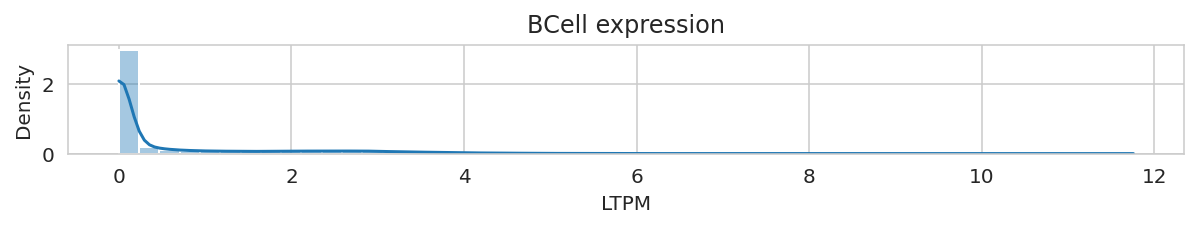

Total genes with positions 58387
Genes logTPM > 0.1 20769
Saved expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1_tss2000.bed
TCell /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv


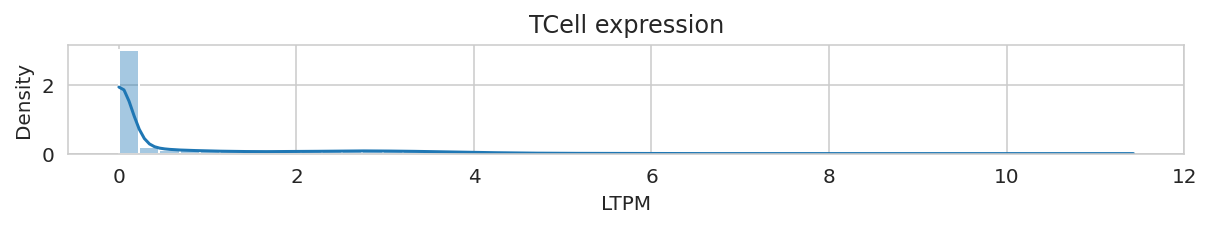

Total genes with positions 58387
Genes logTPM > 0.1 21110
Saved expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1_tss2000.bed
Monocyte /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv


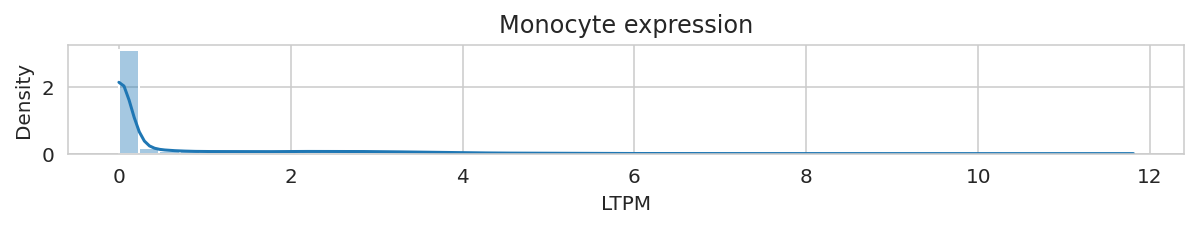

Total genes with positions 58387
Genes logTPM > 0.1 18584
Saved expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1_tss2000.bed


In [6]:
import re

PATH = os.path.expanduser('~/data/2023_Immune')

EXPRESSION_TSV = {
    'BCell': PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    'TCell': PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    'Monocyte': PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

EXPRESSION_TSS_BED = {}
THRESHOLD = 0.1
TSS=2000

for cell, path in EXPRESSION_TSV.items():
    print(cell, path)
    t = pd.read_csv(path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    plt.figure(figsize=(10, 1))
    ax = plt.axes()
    g_results = sns.histplot(data=t, x='LTPM', ax=ax,
                             stat='density',
                             bins=50, kde=True, alpha=0.4)
    ax.title.set_text(f'{cell} expression')
    plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    starts = [
        max(1, start - TSS) if strand == '+' else end - TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    ends = [
        start + TSS if strand == '+' else end + TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    full_df['start'] = starts
    full_df['end'] = ends
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)

    expr_path = path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_TSS_BED[cell] = expr_path


## Load peaks

In [7]:
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me3']

def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, fdr, ps, avls)
    return df_fdr

In [8]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2['file']]
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2broad['file']]
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['file'] = [f'{PATH}/sicer/{f}' for f in df_fdr_sicer['file']]
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['file'] = [f'{PATH}/span/{f}' for f in df_fdr_span['file']]
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/48 [00:00<?, ?it/s]

Monocyte_H3K4me3_hg38_ENCFF642LZZ_q0.05_peaks.narrowPeak 0.05 Monocyte H3K4me3
Monocyte_H3K36me3_hg38_ENCFF164MUD_q0.05_peaks.narrowPeak 0.05 Monocyte None
TCell_H3K4me3_hg38_ENCFF661HCG_q0.05_peaks.narrowPeak 0.05 TCell H3K4me3
TCell_H3K36me3_hg38_ENCFF783YIM_q0.05_peaks.narrowPeak 0.05 TCell None
BCell_H3K4me3_hg38_ENCFF213VRU_q0.05_peaks.narrowPeak 0.05 BCell H3K4me3
BCell_H3K36me3_hg38_ENCFF207YSM_q0.05_peaks.narrowPeak 0.05 BCell None
MACS2 3


  0%|          | 0/48 [00:00<?, ?it/s]

Monocyte_H3K4me3_hg38_ENCFF642LZZ_broad0.1_peaks.broadPeak 0.1 Monocyte H3K4me3
Monocyte_H3K36me3_hg38_ENCFF164MUD_broad0.1_peaks.broadPeak 0.1 Monocyte None
BCell_H3K36me3_hg38_ENCFF207YSM_broad0.1_peaks.broadPeak 0.1 BCell None
BCell_H3K4me3_hg38_ENCFF213VRU_broad0.1_peaks.broadPeak 0.1 BCell H3K4me3
TCell_H3K36me3_hg38_ENCFF783YIM_broad0.1_peaks.broadPeak 0.1 TCell None
TCell_H3K4me3_hg38_ENCFF661HCG_broad0.1_peaks.broadPeak 0.1 TCell H3K4me3
MACS2 broad 3


  0%|          | 0/57 [00:00<?, ?it/s]

TCell_H3K4me3_hg38_ENCFF661HCG-W200-G600-islands-summary-FDR0.01 0.01 TCell H3K4me3
BCell_H3K36me3_hg38_ENCFF207YSM-W200-G600-islands-summary-FDR0.01 0.01 BCell None
Monocyte_H3K4me3_hg38_ENCFF642LZZ-W200-G600-islands-summary-FDR0.01 0.01 Monocyte H3K4me3
TCell_H3K36me3_hg38_ENCFF783YIM-W200-G600-islands-summary-FDR0.01 0.01 TCell None
Monocyte_H3K36me3_hg38_ENCFF164MUD-W200-G600-islands-summary-FDR0.01 0.01 Monocyte None
BCell_H3K4me3_hg38_ENCFF213VRU-W200-G600-islands-summary-FDR0.01 0.01 BCell H3K4me3
SICER 3


  0%|          | 0/9 [00:00<?, ?it/s]

BCell_H3K36me3_hg38_ENCFF207YSM_200_q0.05.peak 0.05 BCell None
Monocyte_H3K4me3_hg38_ENCFF642LZZ_200_q0.05.peak 0.05 Monocyte H3K4me3
TCell_H3K4me3_hg38_ENCFF661HCG_200_q0.05.peak 0.05 TCell H3K4me3
TCell_H3K36me3_hg38_ENCFF783YIM_200_q0.05.peak 0.05 TCell None
Monocyte_H3K36me3_hg38_ENCFF164MUD_200_q0.05.peak 0.05 Monocyte None
BCell_H3K4me3_hg38_ENCFF213VRU_200_q0.05.peak 0.05 BCell H3K4me3
SPAN 3


file modification      cell  \
0  /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K4me3  Monocyte   
2  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me3     BCell   
2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me3     TCell   
1  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me3     TCell   
1  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3     TCell   

    fdr  peaks     avlength         tool  
0  0.05  26555   996.763623        MACS2  
2  0.05  20615  1559.649187         SPAN  
2   0.1  28929  1235.662035  MACS2 broad  
1  0.05  31242  1059.360252        MACS2  
1  0.05  23771  1702.898153         SPAN

In [9]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'Genes']
palette = plt.cm.get_cmap('tab10', len(TOOLS))
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

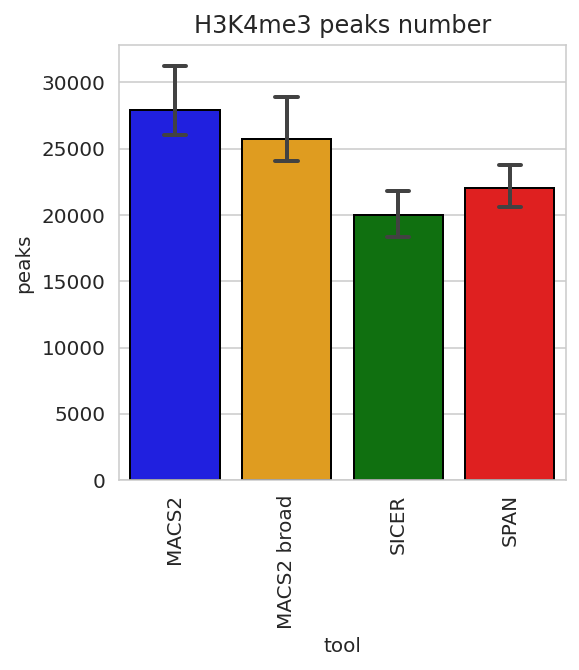

In [18]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me3 peaks number')
plt.show()

In [19]:
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

name  length
76552         SICER    1799
88042         SICER    4199
107371         SPAN    1869
49551   MACS2 broad    1872
111645         SPAN    1220
116328         SPAN     763
90441          SPAN    1358
79768         SICER    1199
63113         SICER    2599
75858         SICER    1599

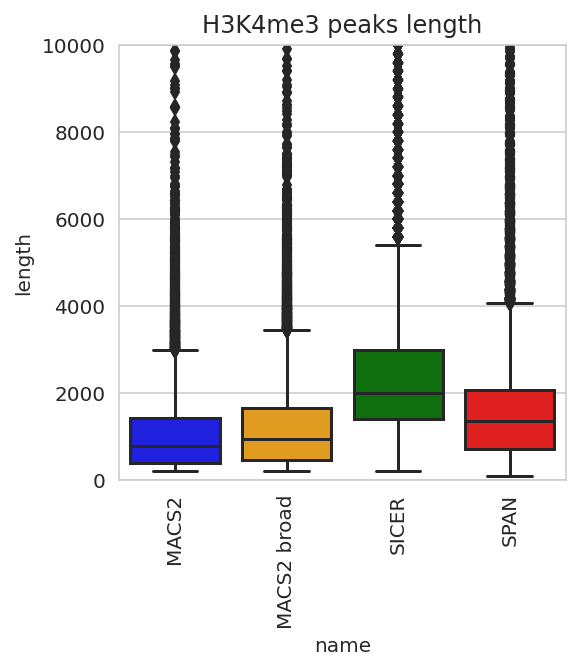

In [20]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax, palette=TOOLS_PALETTE)
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 10_000])
plt.show()

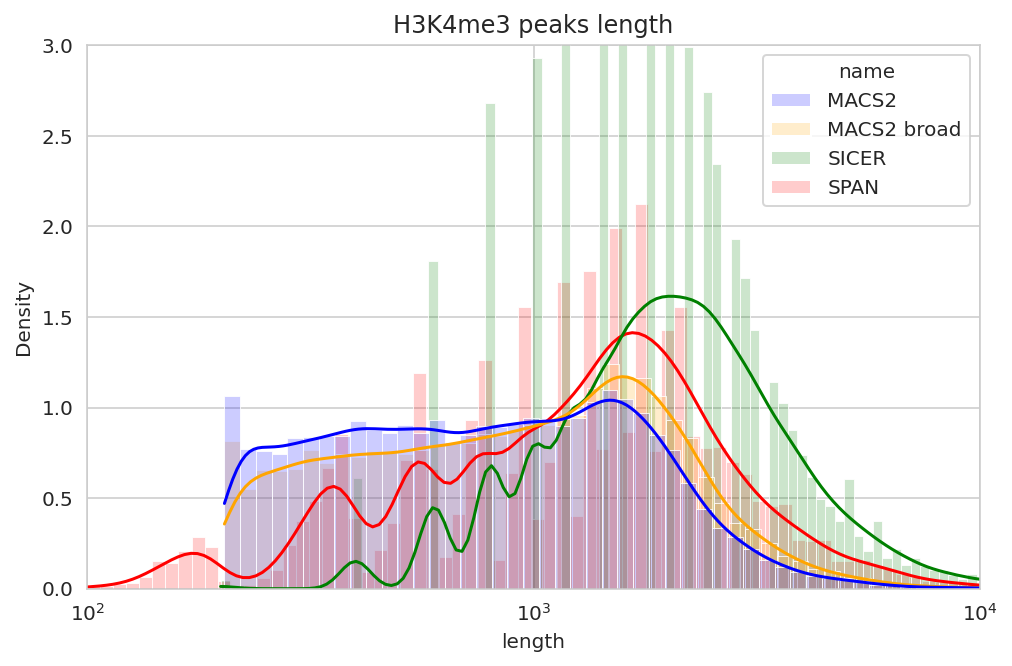

In [23]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 1e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

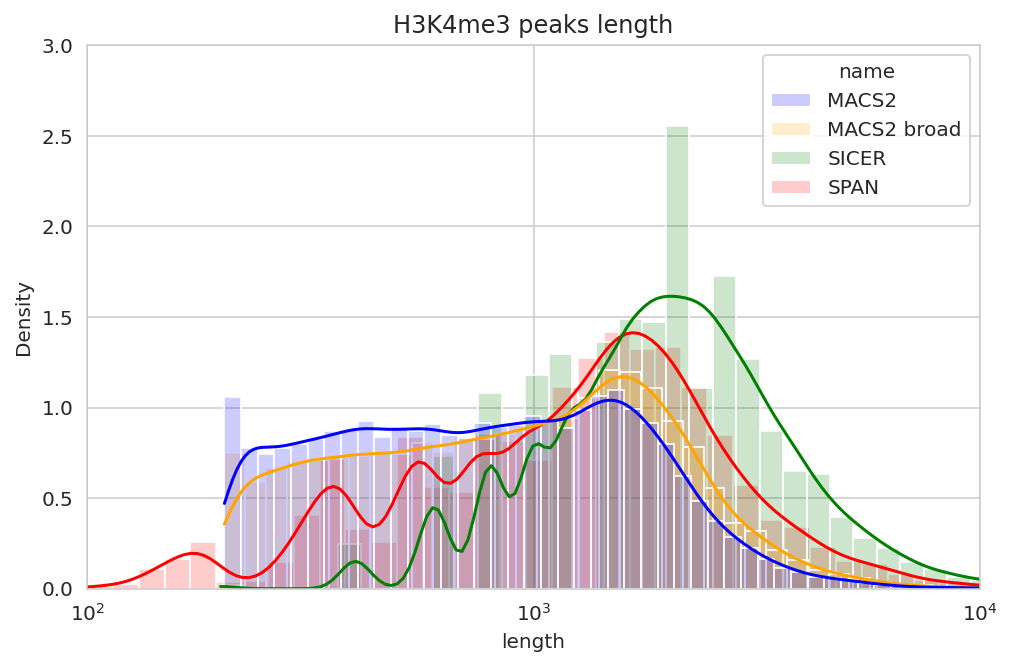

In [24]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 1e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

In [25]:
# Randomly tweak SPAN, SICER lengths for visualization purposes
tsicer = t['name'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))
tspan = t['name'] == 'SPAN'
t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


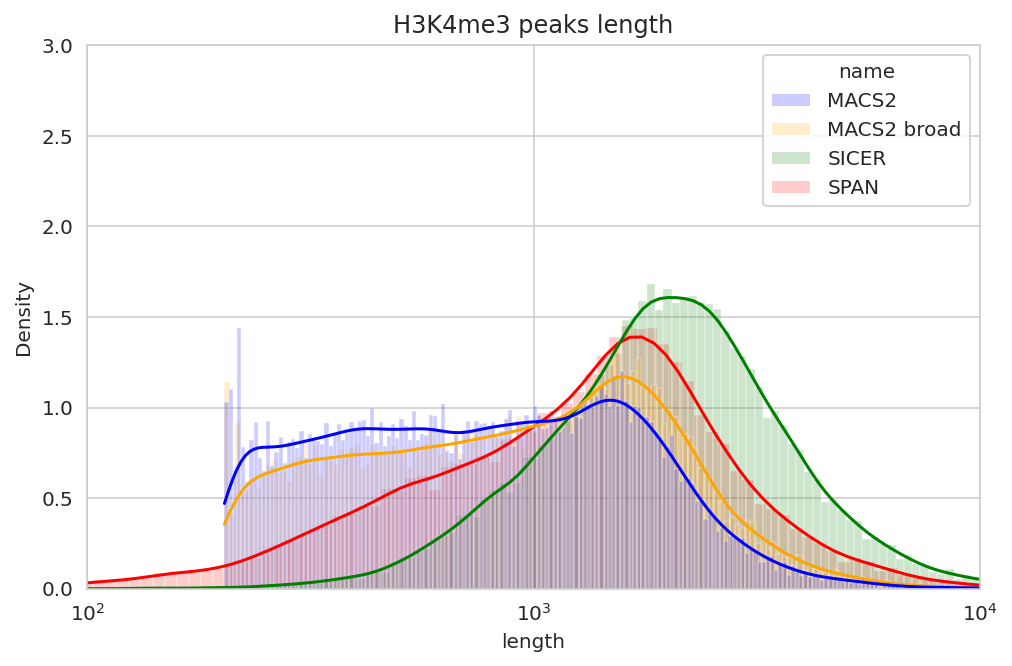

In [26]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=200, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 1e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

## Overlap H3K4me3 vs genes TSS

In [28]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'overlap', 'peaks', 'genes', 'peaks_overlap', 'genes_overlap'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    expr_file = EXPRESSION_TSS_BED[c]
    genes = lines(expr_file)
    print(f'Cell {c} genes {genes}')
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        for overlap, overlap_param in [
            ('1bp overlap', ''),
            ('50% overlap', ' -f 0.5 '),
            ('80% overlap', ' -f 0.8 '),
        ]:
            !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
            peaks_overlap = lines(tf)
            !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
            genes_overlap = lines(tf)
            bench_df.loc[len(bench_df)] = (c, tool, overlap, peaks, genes, peaks_overlap, genes_overlap)
bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

Cell BCell genes 20769
Cell TCell genes 21110
Cell Monocyte genes 18584


cell         name      overlap  peaks  genes  peaks_overlap  \
0      BCell        MACS2  1bp overlap  26066  20769          14649   
1      BCell        MACS2  50% overlap  26066  20769          14277   
2      BCell        MACS2  80% overlap  26066  20769          13741   
3      BCell  MACS2 broad  1bp overlap  24118  20769          13011   
4      BCell  MACS2 broad  50% overlap  24118  20769          12651   
5      BCell  MACS2 broad  80% overlap  24118  20769          12096   
6      BCell         SPAN  1bp overlap  20615  20769          10976   
7      BCell         SPAN  50% overlap  20615  20769          10607   
8      BCell         SPAN  80% overlap  20615  20769           9856   
9      BCell        SICER  1bp overlap  18342  20769          10725   
10     BCell        SICER  50% overlap  18342  20769          10123   
11     BCell        SICER  80% overlap  18342  20769           8477   
12     TCell        MACS2  1bp overlap  31242  21110          15677   
13     TCell        MACS2  50% overlap  31242  21110          15155   
14     TCell        MACS2  80% overlap  31242  21110          14388   
15     TCell  MACS2 broad  1bp overlap  28929  21110          13735   
16     TCell  MACS2 broad  50% overlap  28929  21110          13202   
17     TCell  MACS2 broad  80% overlap  28929  21110          12346   
18     TCell         SPAN  1bp overlap  23771  21110          11362   
19     TCell         SPAN  50% overlap  23771  21110          10761   
20     TCell         SPAN  80% overlap  23771  21110           9721   
21     TCell        SICER  1bp overlap  21785  21110          11240   
22     TCell        SICER  50% overlap  21785  21110          10394   
23     TCell        SICER  80% overlap  21785  21110           8786   
24  Monocyte        MACS2  1bp overlap  26555  18584          14961   
25  Monocyte        MACS2  50% overlap  26555  18584          14553   
26  Monocyte        MACS2  80% overlap  26555  18584          13919   
27  Monocyte  MACS2 broad  1bp overlap  24096  18584          13020   
28  Monocyte  MACS2 broad  50% overlap  24096  18584          12631   
29  Monocyte  MACS2 broad  80% overlap  24096  18584          11965   
30  Monocyte         SPAN  1bp overlap  21778  18584          10599   
31  Monocyte         SPAN  50% overlap  21778  18584          10197   
32  Monocyte         SPAN  80% overlap  21778  18584           9268   
33  Monocyte        SICER  1bp overlap  19955  18584          10468   
34  Monocyte        SICER  50% overlap  19955  18584           9965   
35  Monocyte        SICER  80% overlap  19955  18584           8765   

    genes_overlap  
0           13982  
1            3041  
2             207  
3           14035  
4            4020  
5             330  
6           14058  
7            5235  
8             680  
9           13936  
10           9455  
11           2588  
12          14464  
13           4066  
14            375  
15          14526  
16           5375  
17            554  
18          14579  
19           6812  
20           1036  
21          14504  
22           9545  
23           2400  
24          13257  
25           2687  
26            218  
27          13303  
28           3666  
29            348  
30          13469  
31           5883  
32            897  
33          13375  
34           7392  
35           1489

In [29]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

In [30]:
# print('Ignore outliers')
# print(len(bench_df[bench_df['precision'] < 0.1]))
# bench_df = bench_df[bench_df['precision'] >= 0.1]

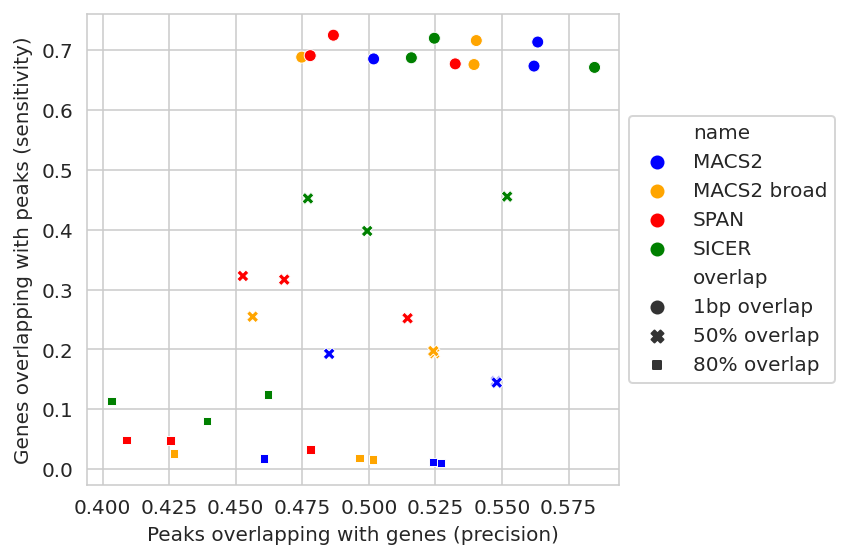

In [31]:
import seaborn as sns

plt.figure(figsize=(6, 4))
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name', style='overlap',
                            palette=TOOLS_PALETTE)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_results.axes.set_xlabel('Peaks overlapping with genes (precision)')
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.tight_layout()
plt.show()

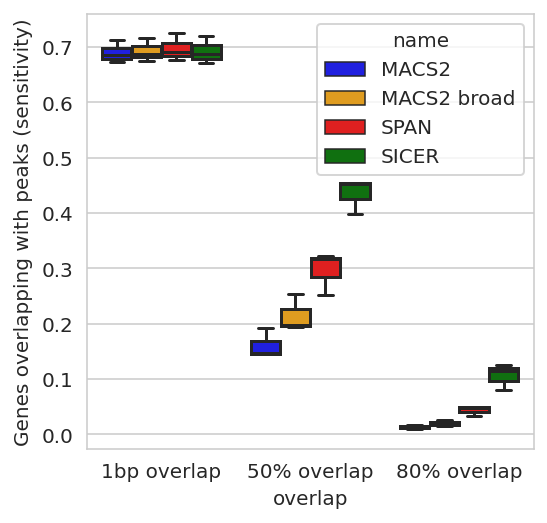

In [32]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='sensitivity', hue='name',
                        palette=TOOLS_PALETTE)
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.show()

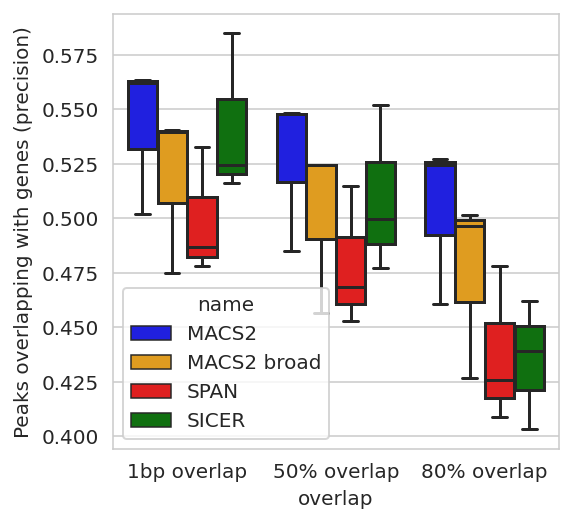

In [33]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='precision', hue='name',
                        palette=TOOLS_PALETTE)
g_results.axes.set_ylabel('Peaks overlapping with genes (precision)')
plt.show()

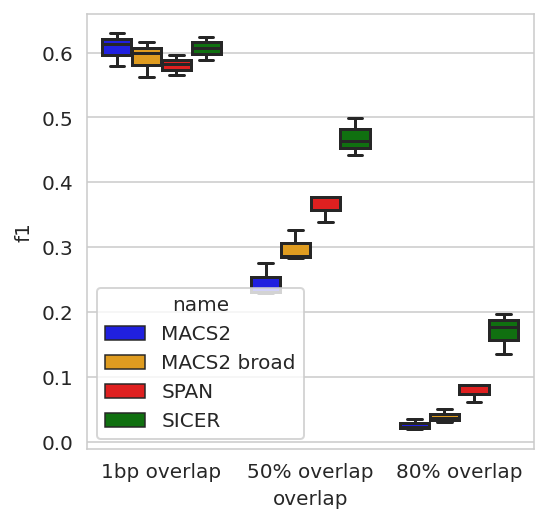

In [34]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=bench_df, x='overlap', y='f1', hue='name',
            palette=TOOLS_PALETTE)
plt.show()

## Compare H3K4me3 difference of SPAN with other tools with expressed genes TSS

In [39]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'overlap', 'peaks', 'peaks_overlap', 'genes', 'genes_overlap'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()


for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = EXPRESSION_TSS_BED[c]
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = t['file'].values[0]
    genes = lines(expr_file)
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            for overlap, overlap_param in [
                ('1bp overlap', ''),
                ('50% overlap', '-f 0.5'),
                ('80% overlap', '-f 0.8')
            ]:
                !bedtools intersect {args} -wa -v > {tf}
                !bedtools intersect -a {tf} -b {expr_file} -wa -u {overlap_param} > {tf2}
                peaks, peaks_overlap = lines(tf), lines(tf2)
                !bedtools intersect -b {tf} -a {expr_file} -wa -u {overlap_param} > {tf2}
                genes_overlap = lines(tf2)
                diff_bench_df.loc[len(diff_bench_df)] = \
                    (c, name, overlap, peaks, peaks_overlap, genes, genes_overlap)

display(diff_bench_df.head())

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell          name      overlap  peaks  peaks_overlap  genes  \
0  BCell  SPAN - MACS2  1bp overlap   1255             83  20769   
1  BCell  SPAN - MACS2  50% overlap   1255             81  20769   
2  BCell  SPAN - MACS2  80% overlap   1255             77  20769   
3  BCell  MACS2 - SPAN  1bp overlap    164             22  20769   
4  BCell  MACS2 - SPAN  50% overlap    164             21  20769   

   genes_overlap  
0             89  
1              0  
2              0  
3             22  
4              0

In [40]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

In [41]:
full_diff_bench_df = pd.concat([bench_df[['cell', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']],
                                diff_bench_df[['cell', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']]]).reset_index(drop=True)
full_diff_bench_df

cell          name  peaks      overlap  precision  sensitivity
0      BCell         MACS2  26066  1bp overlap   0.561996     0.673215
1      BCell         MACS2  26066  50% overlap   0.547725     0.146420
2      BCell         MACS2  26066  80% overlap   0.527162     0.009967
3      BCell   MACS2 broad  24118  1bp overlap   0.539473     0.675767
4      BCell   MACS2 broad  24118  50% overlap   0.524546     0.193558
..       ...           ...    ...          ...        ...          ...
85  Monocyte  SPAN - SICER   1775  50% overlap   0.079437     0.000000
86  Monocyte  SPAN - SICER   1775  80% overlap   0.078873     0.000000
87  Monocyte  SICER - SPAN     34  1bp overlap   0.029412     0.000054
88  Monocyte  SICER - SPAN     34  50% overlap   0.000000     0.000000
89  Monocyte  SICER - SPAN     34  80% overlap   0.000000     0.000000

[90 rows x 6 columns]

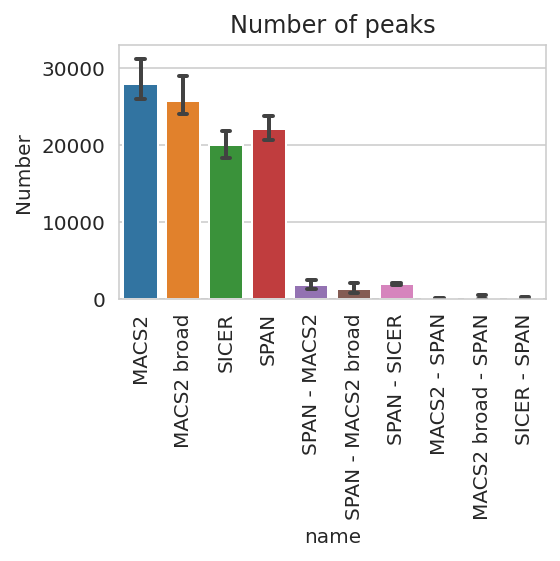

In [47]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Number of peaks')
g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['overlap'] == '1bp overlap'], x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(top=33_000)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.show()

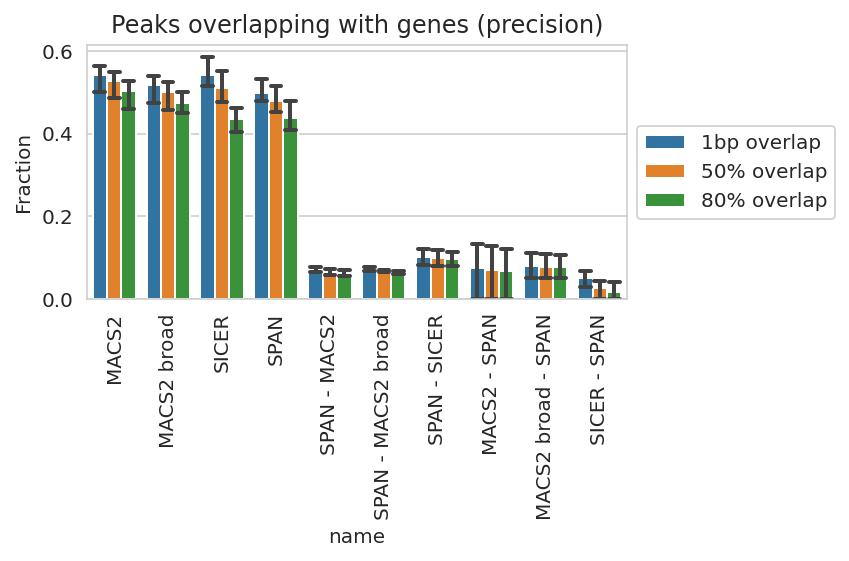

In [48]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Peaks overlapping with genes (precision)')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='precision',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

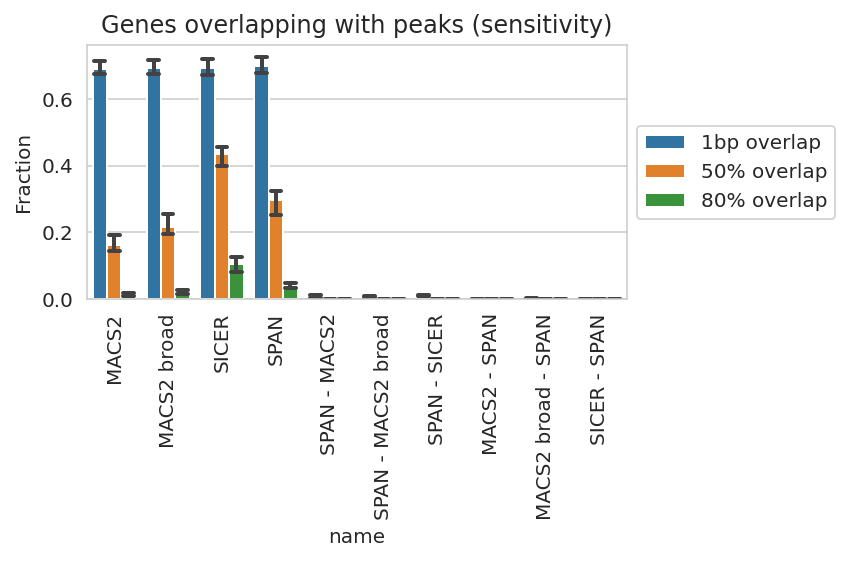

In [49]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks (sensitivity)')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='sensitivity',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

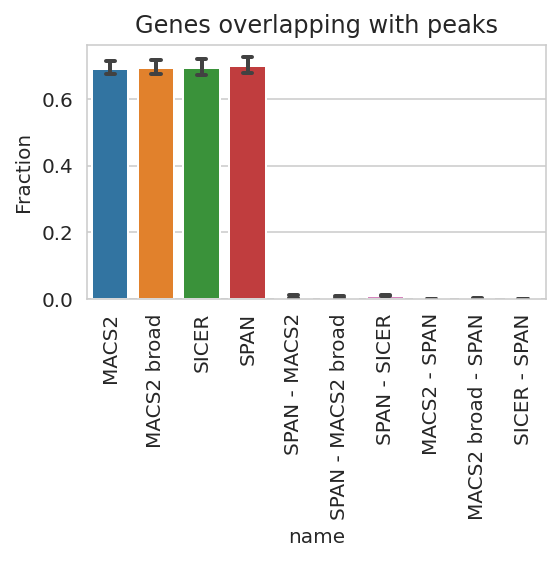

In [50]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks')
g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['overlap'] == '1bp overlap'], x='name', y='sensitivity',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

## Hg38 Recovered promoter fraction / Correct peak fraction

In [51]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_df = pd.DataFrame(
    columns=['cell', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in EXPRESSION_TSS_BED:
        continue
    expr_file = EXPRESSION_TSS_BED[c]
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {expr_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {expr_file} -wa -u > {tf2}
            genes_overlap = lines(tf2)
            benchmark_df.loc[len(benchmark_df)] = \
                (c, top, genes, peaks_file, peaks, peaks_overlap, genes_overlap, tool)

benchmark_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell      top  genes  \
0       BCell   1000.0  20769   
1       BCell   2000.0  20769   
2       BCell   3000.0  20769   
3       BCell   4000.0  20769   
4       BCell   5000.0  20769   
..        ...      ...    ...   
175  Monocyte  11000.0  18584   
176  Monocyte  12000.0  18584   
177  Monocyte  13000.0  18584   
178  Monocyte  14000.0  18584   
179  Monocyte  15000.0  18584   

                                            peaks_file  peaks    pg     gp  \
0    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   1000   915   1370   
1    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   2000  1824   2677   
2    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   3000  2723   3925   
3    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   4000  3599   5137   
4    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   5000  4484   6300   
..                                                 ...    ...   ...    ...   
175  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  11000  7586  10180   
176  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  12000  8066  10739   
177  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  13000  8486  11220   
178  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  14000  8860  11637   
179  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  15000  9220  12039   

      tool  
0    MACS2  
1    MACS2  
2    MACS2  
3    MACS2  
4    MACS2  
..     ...  
175  SICER  
176  SICER  
177  SICER  
178  SICER  
179  SICER  

[180 rows x 8 columns]

In [54]:
benchmark_df['p'] = (benchmark_df['pg'] + benchmark_df['gp']) / 2
benchmark_df['precision'] = [d(x, y) for x, y in zip(benchmark_df['pg'], benchmark_df['peaks'])]
benchmark_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_df['gp'], benchmark_df['genes'])]
benchmark_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_df['sensitivity'], benchmark_df['precision'])]
benchmark_df

cell      top  genes  \
0       BCell   1000.0  20769   
1       BCell   2000.0  20769   
2       BCell   3000.0  20769   
3       BCell   4000.0  20769   
4       BCell   5000.0  20769   
..        ...      ...    ...   
175  Monocyte  11000.0  18584   
176  Monocyte  12000.0  18584   
177  Monocyte  13000.0  18584   
178  Monocyte  14000.0  18584   
179  Monocyte  15000.0  18584   

                                            peaks_file  peaks    pg     gp  \
0    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   1000   915   1370   
1    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   2000  1824   2677   
2    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   3000  2723   3925   
3    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   4000  3599   5137   
4    /home/jetbrains/data/2023_Immune/macs2/BCell_H...   5000  4484   6300   
..                                                 ...    ...   ...    ...   
175  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  11000  7586  10180   
176  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  12000  8066  10739   
177  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  13000  8486  11220   
178  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  14000  8860  11637   
179  /home/jetbrains/data/2023_Immune/sicer/Monocyt...  15000  9220  12039   

      tool        p  precision  sensitivity        f1  
0    MACS2   1142.5   0.915000     0.065964  0.123056  
1    MACS2   2250.5   0.912000     0.128894  0.225866  
2    MACS2   3324.0   0.907667     0.188984  0.312833  
3    MACS2   4368.0   0.899750     0.247340  0.388015  
4    MACS2   5392.0   0.896800     0.303337  0.453336  
..     ...      ...        ...          ...       ...  
175  SICER   8883.0   0.689636     0.547783  0.610579  
176  SICER   9402.5   0.672167     0.577863  0.621457  
177  SICER   9853.0   0.652769     0.603745  0.627301  
178  SICER  10248.5   0.632857     0.626184  0.629503  
179  SICER  10629.5   0.614667     0.647815  0.630806  

[180 rows x 12 columns]

In [55]:
import plotly.graph_objects as go

def plot_top(benchmark_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_df[(benchmark_df['cell'] == c) &
                           (benchmark_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=TOOLS_PALETTE[t],
            opacity=0.3,
        ))
        tools_legend_shown.add(t)

    # for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
    #     dft = benchmark_df[(benchmark_df['cell'] == c) & (benchmark_df['replicate'] == r) &
    #                        (benchmark_df['tool'] == t) &
    #                        (benchmark_df['top'] != 1000)]
    #     if len(dft) == 0:
    #         continue
    #     fig.add_trace(
    #         go.Scatter(
    #             mode='markers',
    #             x=dft["precision"], y=dft["sensitivity"],
    #             name=t,
    #             marker=dict(color='white', size=3, line=dict(width=1)),
    #             showlegend=False,
    #             hovertext=dft['top'].astype(str) + ' ' + t,
    #             opacity=0.3,
    #         )
    #     )
    #
    #
    # marker = 'square' if overlap == '1bp overlap' else  'circle' if overlap == '50% overlap' else 'diamond'
    # for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
    #     dft = benchmark_df[(benchmark_df['cell'] == c) & (benchmark_df['replicate'] == r) &
    #                        (benchmark_df['tool'] == t) &
    #                        (benchmark_df['top'] == 1000)]
    #     if len(dft) == 0:
    #         continue
    #     fig.add_trace(
    #         go.Scatter(
    #             mode='markers',
    #             x=dft["precision"], y=dft["sensitivity"],
    #             name=t,
    #             marker=dict(color='white', size=5, line=dict(width=1)),
    #             showlegend=False,
    #             hovertext=dft['top'].astype(str) + ' ' + t
    #         )
    #     )

    # fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping active genes (precision)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Active genes overlapping peaks (sensitivity)')
    fig.update_xaxes(title='Correct promoter fraction (sensitivity)')
    fig.update_yaxes(title='Recovered promoter fraction (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)
    fig.show()


In [56]:
plot_top(benchmark_df)